<a href="https://colab.research.google.com/github/Svarich-11908/machine-learning/blob/main/11_009_Svarich_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание на регрессию. Немного о переобучении и недобучении. Кроссвалидация. Подбор параметров.

# ДЗ:
1. Сделать разведочный анализ данных, найти пропуски и выбросы. Примеры есть в ноутбуке EDA_AUTO из 4 задания.
2. Заполнить пропуски. Заполнить медианой или обучить линейную регрессию и заполнить ею пропуски. Если заполните линейной регрессией пропуски, то с помощью таблицы корреляций найдите второй признак, который имеет сильную взаимосвязь с первым признаком. Создаете отдельный датафрейм из этих признаков, исключаете пропуски (не удаляете), обучаете линейну регрессию. Затем прогнозируете на исключенных данных с пропусками и заполняете эти пропуски предсказанным значением.
3. Обучить множественную линейную регрессию. Она будет являться base line, т.е. базовая модель. С ней вы будете сравнивать другие модели.
4. Используя кроссвалидацию, подбор гиперпараметров обучить модели Lasso regression, Ridge Regression, ElasticNet (модель где Ridge + Lasso вместе используется), DecisionTreeRegressor, SVR, RandomForestRegressor

5. `alphas=[0.0001, 0.001,0.01, 0.1, 1, 10]` - для MultiTaskLassoCV, RidgeCV, и для ElasticNetCV.

`'l1_ratio':[0.01, 0.1, 0.5, 1, 5, 10, 15, 20]` - для ElasticNetCV

6. **для SVR и RandomForest:**
```python
param_grid = [{'regressor':[SVR()], 'preprocessing':[StandardScaler(), None],
              'regressor__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'regressor': [DecisionTreeRegressor()],
               'preprocessing': [None],
               'regressor__max_features': [1, 2, 3]},
              {'regressor': [RandomForestRegressor(n_estimators=100)],
               'preprocessing': [None],
               'regressor__max_features': [1, 2, 3]}]
```

7. **Если SVR обучается, то используем только этот набор параметров:**
```python
param_grid={
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}
```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from google.colab import files

uploaded = files.upload()



Saving data.csv to data (1).csv


In [ ]:
df = pd.read_csv('data.csv')
df.describe()

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
count,29712.000000,29712.000000,29712.000000,29712.000000,27711.000000,29712.000000,29712.000000
mean,50.075761,51.582940,496.375057,1228.936047,925.288586,123.147985,51.579620
std,0.004490,0.718957,16.656003,9.293723,12.649640,2.293297,58.430508
min,50.067757,50.118885,458.647290,1207.311621,910.000195,118.375299,51.074956
25%,50.072440,50.940938,484.903076,1222.372168,915.022510,121.428400,51.183080
50%,50.074476,51.725804,490.411133,1228.801709,920.266797,123.233508,51.244438
75%,50.079485,52.134428,509.792322,1236.431030,936.632568,125.019626,51.271976
max,50.089918,53.053829,526.688867,1264.442773,977.826953,128.815308,10123.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29712 entries, 0 to 29711
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   KS4_GPA5_Qtg.PV    29712 non-null  float64
 1   KS4_GPA5_TC_T1.PV  29712 non-null  float64
 2   KS4_GPA5_Nst.PV    29712 non-null  float64
 3   KS4_GPA5_Nvd.PV    29712 non-null  float64
 4   KS4_GPA5_Nnd.PV    27711 non-null  float64
 5   KS4_GPA5_T4.PV     29712 non-null  float64
 6   KS4_GPA5_Pk.PV     29712 non-null  float64
dtypes: float64(7)
memory usage: 1.6 MB


In [ ]:
inputs = ['KS4_GPA5_Qtg.PV', 'KS4_GPA5_TC_T1.PV', 'KS4_GPA5_Nst.PV']
outputs = ['KS4_GPA5_Nvd.PV', 'KS4_GPA5_Nnd.PV', 'KS4_GPA5_T4.PV', 'KS4_GPA5_Pk.PV']

In [ ]:
missing_data = df.isnull().sum()
print("Пропуски в данных:")
print(missing_data)
print('')

columns_with_missing_values = missing_data[missing_data > 0].index.tolist()
print("Столбцы с пропусками:")
print(columns_with_missing_values)

Пропуски в данных:
KS4_GPA5_Qtg.PV         0
KS4_GPA5_TC_T1.PV       0
KS4_GPA5_Nst.PV         0
KS4_GPA5_Nvd.PV         0
KS4_GPA5_Nnd.PV      2001
KS4_GPA5_T4.PV          0
KS4_GPA5_Pk.PV          0
dtype: int64

Столбцы с пропусками:
['KS4_GPA5_Nnd.PV']


In [ ]:
for label in inputs + outputs:
    median = df[label].median()
    df[label].fillna(median, inplace=True)

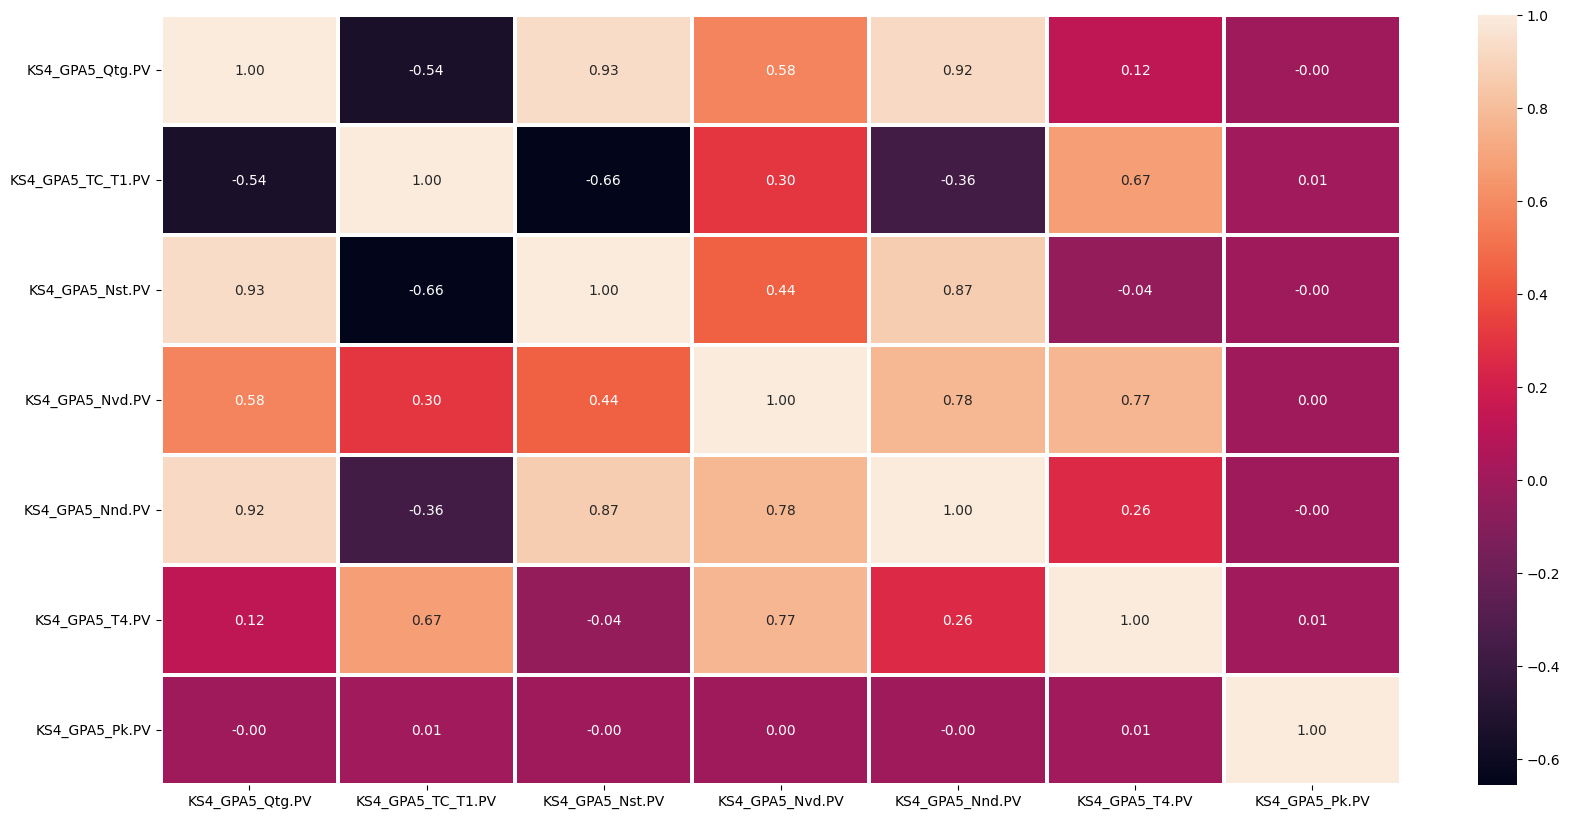

In [ ]:
corr = df.corr()
f,ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, annot=True, linewidths=1.5 , fmt='.2f',ax=ax)
plt.show()

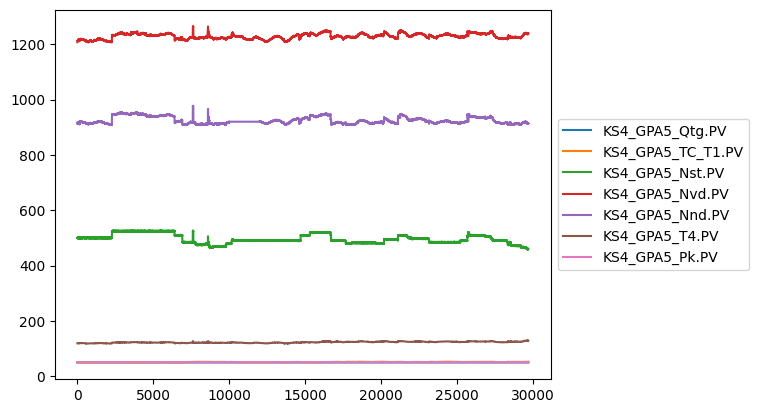

In [ ]:
column_list = df.columns
ax = df[column_list].plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Обнаружен пробел в 'KS4_GPA5_Nnd.PV'

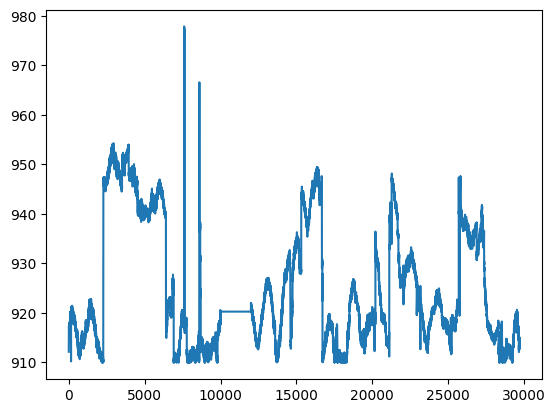

In [ ]:
ax_nnd=df['KS4_GPA5_Nnd.PV'].plot()

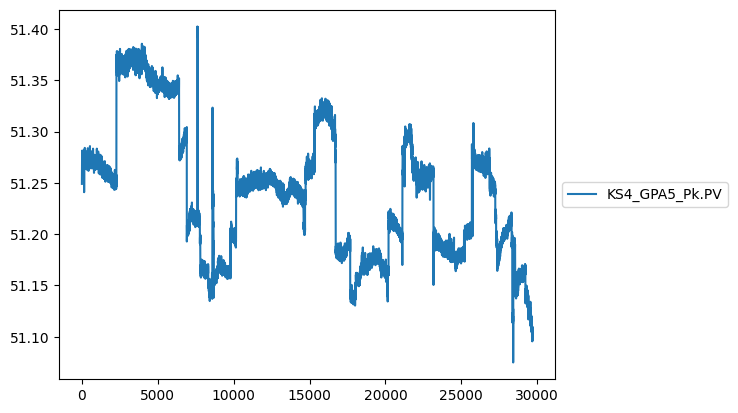

In [ ]:
df = df.drop(df[df['KS4_GPA5_Pk.PV'] > 8000].index)
df['KS4_GPA5_Pk.PV'].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

Исправленно

In [47]:
x, y = df[inputs].to_numpy(), df[outputs].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0, shuffle=True)
model = LinearRegression()
model.fit(x_train, y_train)
print(f'train: {model.score(x_train, y_train)}')
print(f'test: {model.score(x_test, y_test)}')

train: 0.8819428428191922
test: 0.8836769668066163


In [ ]:
lasso_model = Lasso()
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5)
lasso_grid.fit(x_train, y_train)
print("Лучшие параметры для Lasso:", lasso_grid.best_params_)
print('')
print(f'test: {lasso_grid.score(x_test, y_test)}')
print(f'train: {lasso_grid.score(x_train, y_train)}')

Лучшие параметры для Lasso: {'alpha': 0.001}

test: 0.8613411442266967
train: 0.8620125282792082


In [ ]:
# Ridge Regression
ridge_model = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5)
ridge_grid.fit(x_train, y_train)
print("Лучшие параметры для Ridge:", ridge_grid.best_params_)
print('')
print(f'test: {ridge_grid.score(x_test, y_test)}')
print(f'train: {ridge_grid.score(x_train, y_train)}')

Лучшие параметры для Ridge: {'alpha': 0.001}

test: 0.8835722901094936
train: 0.8819247585750009


In [ ]:
elasticnet_model = ElasticNet()
elasticnet_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elasticnet_grid = GridSearchCV(elasticnet_model, elasticnet_params, cv=5)
elasticnet_grid.fit(x_train, y_train)
print("Лучшие параметры для ElasticNet:", elasticnet_grid.best_params_)
print('')
print(f'test: {elasticnet_grid.score(x_test, y_test)}')
print(f'train: {elasticnet_grid.score(x_train, y_train)}')

Лучшие параметры для ElasticNet: {'alpha': 0.001, 'l1_ratio': 0.9}

test: 0.8317467723974459
train: 0.8338691644940741


In [ ]:
dt_model = DecisionTreeRegressor()
dt_params = {'max_depth': [None, 10, 20, 30, 40, 50]}
dt_grid = GridSearchCV(dt_model, dt_params, cv=5)
dt_grid.fit(x_train, y_train)
print("Лучшие параметры для Decision Tree:", dt_grid.best_params_)
print('')
print(f'test: {dt_grid.score(x_test, y_test)}')
print(f'train: {dt_grid.score(x_train, y_train)}')

Лучшие параметры для Decision Tree: {'max_depth': 20}

test: 0.9866847277714408
train: 0.9991893731249066


In [ ]:
param_grid = {'estimator__gamma': [0.001, 0.01], 'estimator__C': [0.001, 0.01],}

svr_model = SVR()
multioutput_regressor = MultiOutputRegressor(svr_model)
svr_grid = HalvingGridSearchCV(multioutput_regressor, param_grid, cv=3, verbose=2, n_jobs=-1)
svr_grid.fit(x, y)
print("Лучшие параметры для SVR:", svr_grid.best_params_)
print('')
print(f'test: {svr_grid.score(x_test, y_test)}')
print(f'train: {svr_grid.score(x_train, y_train)}')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 9903
max_resources_: 29711
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 9903
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 29709
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Лучшие параметры для SVR: {'estimator__C': 0.001, 'estimator__gamma': 0.001}

test: 0.282730421996263
train: 0.28179322769620296


In [48]:
rf_model = RandomForestRegressor()
rf_params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30, 40, 50]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(x_train, y_train)
print("Лучшие параметры для Random Forest:", rf_grid.best_params_)
print('')
print(f'test: {rf_grid.score(x_test, y_test)}')
print(f'train: {rf_grid.score(x_train, y_train)}')

Лучшие параметры для Random Forest: {'max_depth': 20, 'n_estimators': 200}

test: 0.9926110294375081
train: 0.9987966168257673


Лушчая модель на основе тестовых данных:
1. Decision Tree 0.9866847277714408